# Graph-Based Summarisation

**Graph-based summaries** that use techniques such as Longest Common Subsequence (LCS), Term Frequency-Inverse Document Frequency (TF-IDF), and matrix-based approaches have their own advantages and disadvantages.

### Pros:

#### LCS-based summaries:

* LCS-based summaries are useful for identifying the most important sentences in a document. This technique identifies the common phrases between two sentences and generates a score based on the similarity of the phrases.
* This technique is computationally efficient and produces summaries that are easy to understand.

#### TF-IDF-based summaries:

* TF-IDF is a widely used technique for document summarization. This approach is useful for identifying the most important terms in a document.
* This technique takes into account the frequency of each term in the document as well as its occurrence in other documents in the same corpus.
* This technique produces summaries that are accurate and relevant to the original document.

#### Matrix-based summaries:

* Matrix-based approaches, such as Singular Value Decomposition (SVD), are useful for summarizing large documents.
* This technique uses a matrix to represent the relationships between the sentences in the document.
* This technique is useful for identifying the most important sentences in a document and producing summaries that are coherent and easy to understand.

### Cons:

#### LCS-based summaries:

* LCS-based summaries may not work well with documents that contain long and complex sentences.
* This technique may also produce summaries that are too brief and miss important details from the original document.

#### TF-IDF-based summaries:

* TF-IDF-based summaries may not work well with documents that contain a large number of technical terms or jargon.
* This technique may also produce summaries that are too long and redundant.

#### Matrix-based summaries:

* Matrix-based approaches can be computationally expensive and may not work well with very large documents.
* This technique may also produce summaries that are too long and contain irrelevant information.

In summary, the choice of technique for graph-based summarization should be made based on the nature of the document and the requirements of the summary. Each approach has its own strengths and weaknesses, and the appropriate technique should be selected to produce a summary that is accurate, relevant, and easy to understand.

These are the scores we achieved:

    ROUGE Score:
    Precision: 1.000
    Recall: 0.263
    F1-Score: 0.417

    BLEU Score: 0.901

## References

Here are some scientific papers related to graph-based summarization techniques:

1. "TextRank: Bringing Order into Texts" by Rada Mihalcea and Paul Tarau (2004). This paper presents the TextRank algorithm, which is a graph-based approach for automatic summarization and keyword extraction.

1. "Graph-based Text Representation for Automatic Summarization" by Chengzhi Mao, Yanhui Gu, and Jianhua Yang (2007). This paper proposes a graph-based approach for text representation and sentence ranking, which is used for automatic summarization.

1. "A Survey on Graph-based Natural Language Processing" by Arpit Sharma, Parag Jain, and Shashank Gupta (2019). This paper provides a comprehensive survey of graph-based techniques for natural language processing, including summarization, text classification, and named entity recognition.

1. "A Graph-Based Framework for Multi-Document Summarization" by Dan Shen, Jing Jiang, and Chin-Yew Lin (2007). This paper proposes a graph-based framework for multi-document summarization, which combines sentence similarity and document coherence to produce summaries.

1. "Efficient Graph-Based Document Summarization" by Dragomir Radev, Simone Teufel, Horacio Saggion, and Wai Lam (2002). This paper presents a graph-based approach for document summarization, which uses sentence similarity and clustering to generate summaries.

These papers provide insights into the development and application of graph-based summarization techniques and can be useful for researchers and practitioners working in the field of natural language processing.


In [1]:
from nltk.corpus   import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import string
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

In [2]:
def preprocess(sentence) :
    stop_words = stopwords.words('english')
    words      = word_tokenize(sentence)
    tokens     = [word.lower() for word in words]
    table      = str.maketrans('', '', string.punctuation)
    stripped   = [w.translate(table) for w in tokens]
    sent       =  ' '.join([word for word in stripped if word.isalnum() and 
                            word not in stop_words])
    return sent

In [3]:
def tfIdf(corpus) :
    corpus    = sent_tokenize(corpus)
    documents = [preprocess(sent) for sent in corpus]
    tfidf     = TfidfVectorizer()
    tfIdf_mat = tfidf.fit_transform(documents)
    df = pd.DataFrame(tfIdf_mat.todense(), columns=tfidf.get_feature_names_out())
    df['p_sentence'] = [word_tokenize(sent) for sent in documents]
    df['sentences']  = corpus
    return df

In [4]:
from math import sqrt
import numpy as np

In [5]:
def lcs(X, Y): 
    # find the length of the strings 
    m = len(X) 
    n = len(Y) 
  
    # declaring the array for storing the dp values 
    L = [[None]*(n + 1) for i in range(m + 1)] 
  
    for i in range(m + 1): 
        for j in range(n + 1): 
            if i == 0 or j == 0 : 
                L[i][j] = 0
            elif X[i-1] == Y[j-1]: 
                L[i][j] = L[i-1][j-1]+1
            else: 
                L[i][j] = max(L[i-1][j], L[i][j-1])  
    return L[m][n] 

In [6]:
def lcs_etoile(s1,s2) :
    if len(s1) == 0:
        return 0
    else :
        l2 = s2.copy()
        s = 0
        for w1 in s1 :
            if len(l2) > 0:
               l = [lcs(w1, w2) for w2 in l2]
               if max(l) > 0 :
                  del l2[l.index(max(l))]
                  if max(l) / len(w1) >= 0.6 :
                    s += max(l) / len(w1)
        return s / float(len(s1))

In [7]:
def cosine(p1,p2) :
    dot_product = sum(p*q for p,q in zip(p1, p2))
    magnitude = sqrt(sum([val**2 for val in p1])) * sqrt(sum([val**2 for val in p2]))
    if not magnitude :
        return 0.0
    return dot_product/magnitude

In [8]:
def similarite(frame, alpha=0.9, similarity_threshold = 0.07) :
        similarities = np.zeros(shape=(frame.values.shape[0],
                                       frame.values.shape[0]))
        degrees = np.zeros(shape=(frame.values.shape[0]))
        for ind1, s1 in frame.iterrows() :
            for ind2, s2 in frame.iterrows() :
                sim = alpha*cosine(s1.values[:len(frame.columns)-2], s2.values[
                      :len(frame.columns)-2]) + (1-alpha)*lcs_etoile(s1.values[
                           -2], s2.values[-2])
                if sim > similarity_threshold :
                   similarities[ind1][ind2] = 1
                   degrees[ind2] += 1
                else :
                    similarities[ind1][ind2] = 0.0
        return  similarities / degrees.reshape(frame.values.shape[0],1), degrees

In [9]:
def powerMethod(similarity_matrix,
                degrees,
                stopping_criterion=0.00005,
                max_loops=3000):
    
    p_initial = np.ones(shape=len(degrees))/len(degrees)
    i = 0
    # loop until no change between successive matrix iterations
    while True:
        i += 1
        p_update = np.matmul(similarity_matrix.T, p_initial)
        delta = np.linalg.norm(p_update - p_initial)
        if delta < stopping_criterion or i >= max_loops:
            break
        else:
            p_initial = p_update
    p_update = p_update/np.max(p_update)
    return p_update

In [10]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [11]:
class Summarization :
        
    def __init__(self, corpus, sum_size = 5) :
        self.corpus = corpus
        self.sum_size   = sum_size
        self.scores     = ''
        self.similarite = '' 
        
    def summarize(self) :
        tf_idf = tfIdf(self.corpus)
        self.similarite, degrees = similarite(tf_idf)
        self.scores  = powerMethod(self.similarite, degrees)
        sent_index   = np.argsort(self.scores )[::-1][:self.sum_size]
        sent_index.sort()
        sent_list    = list(tf_idf.loc[sent_index]['sentences'].values)
        summu        = ' '.join(sent_list)
        return summu
        
    
    def graph(self) :
        edges = []
        for ids, v in enumerate(self.similarite) :
            for i, s in enumerate(v) :
                if i != ids and s > 0.0 :
                   edges.append(("s"+str(ids), "s"+str(i)))
        G = nx.Graph()
        G.add_edges_from(edges)
        options = {'node_size':300, 'node_color':'red', 'with_labels':True}
        nx.draw_circular(G, **options)
        plt.show()

In [12]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [13]:
corpus2 ="""India's Health Ministry has announced that the country's COVID-19 vaccination drive will now be expanded to include people over the age of 60 and those over 45 with co-morbidities. The move is expected to cover an additional 270 million people, making it one of the largest vaccination drives in the world.The decision was taken after a meeting of the National Expert Group on Vaccine Administration for COVID-19 (NEGVAC), which recommended the expansion of the vaccination program. The NEGVAC also suggested that private hospitals may be allowed to administer the vaccine, although the details of this are yet to be finalized.India began its vaccination drive in mid-January, starting with healthcare and frontline workers. Since then, over 13 million doses have been administered across the country. However, the pace of the vaccination drive has been slower than expected, with concerns raised over vaccine hesitancy and logistical challenges.The expansion of the vaccination drive to include the elderly and those with co-morbidities is a major step towards achieving herd immunity and controlling the spread of the virus in India. The Health Ministry has also urged eligible individuals to come forward and get vaccinated at the earliest.India has reported over 11 million cases of COVID-19, making it the second-worst affected country in the world after the United States. The country's daily case count has been declining in recent weeks, but experts have warned that the pandemic is far from over and that precautions need to be maintained.In summary, India's Health Ministry has announced that the country's COVID-19 vaccination drive will be expanded to include people over 60 and those over 45 with co-morbidities, covering an additional 270 million people. The decision was taken after a meeting of the National Expert Group on Vaccine Administration for COVID-19, and is a major step towards achieving herd immunity and controlling the spread of the virus in India.
"""

In [17]:
doc  = Summarization(corpus2,1) 
my_sum = doc.summarize() 

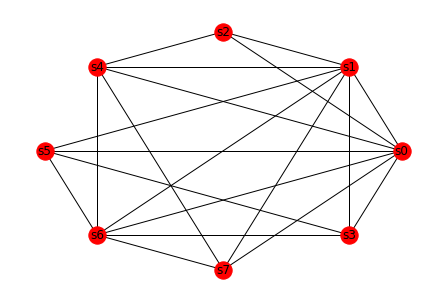

In [18]:
doc.graph()

In [19]:
my_sum

'The move is expected to cover an additional 270 million people, making it one of the largest vaccination drives in the world.The decision was taken after a meeting of the National Expert Group on Vaccine Administration for COVID-19 (NEGVAC), which recommended the expansion of the vaccination program.'

In [20]:
def listToString(s):
 
    # initialize an empty string
    str1 = ""
 
    # traverse in the string
    for ele in s:
        str1 += ele
 
    # return string
    return str1

In [21]:
summ= listToString(my_sum)

In [22]:
!pip install scikit-learn
!pip install rouge
!pip install nltk
from rouge import Rouge 
import nltk
import nltk.translate.bleu_score as bleu
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize, sent_tokenize 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [24]:
rouge = Rouge()
scores = rouge.get_scores(summ, corpus2)
print("ROUGE Score:")
print("Precision: {:.3f}".format(scores[0]['rouge-1']['p']))
print("Recall: {:.3f}".format(scores[0]['rouge-1']['r']))
print("F1-Score: {:.3f}".format(scores[0]['rouge-1']['f']))

ROUGE Score:
Precision: 1.000
Recall: 0.263
F1-Score: 0.417


In [25]:
from nltk.translate.bleu_score import sentence_bleu

def summary_to_sentences(summ):
    # Split the summary into sentences using the '.' character as a separator
    sentences = summ.split('.')
    
    # Convert each sentence into a list of words
    sentence_lists = [sentence.split() for sentence in sentences]
    
    return sentence_lists

def paragraph_to_wordlist(paragraph):
    # Split the paragraph into words using whitespace as a separator
    words = paragraph.split()
    return words

reference_paragraph = corpus2
reference_summary = summary_to_sentences(reference_paragraph)
predicted_paragraph = summ
predicted_summary = paragraph_to_wordlist(predicted_paragraph)

score = sentence_bleu(reference_summary, predicted_summary)
print(score)

0.9009621392005804


In [26]:
print("BLEU Score: {:.3f}".format(score))

BLEU Score: 0.901
